In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

def parse_tcp_file(filename):
    """Parses the TCP packet log file to extract time and packet sizes."""
    data = pd.read_csv(filename, names=["Time", "SrcPort", "DstPort", "Length"], skiprows=1)
    data["Time"] = pd.to_numeric(data["Time"], errors='coerce')
    data["Length"] = pd.to_numeric(data["Length"], errors='coerce')
    return data

def parse_tx_power_file(filename):
    """Parses the TX power log file to extract time, power values, and count packet transmissions."""
    times = []
    powers = []
    packet_count = 0

    with open(filename, 'r') as file:
        for line in file:
            match = re.search(r'Time: ([\d\.]+)s.*New Power: ([-\d]+) dBm', line)
            if match:
                times.append(float(match.group(1)))
                powers.append(int(match.group(2)))
                packet_count += 1  # Count the number of transmission events

    return pd.DataFrame({"Time": times, "Power": powers}), packet_count

def compute_throughput(tcp_data, window_size=0.1):
    """Compute TCP throughput using a sliding window."""
    time_range = np.arange(tcp_data["Time"].min(), tcp_data["Time"].max(), window_size)
    thr_output = []
    for t in time_range:
        filtered = tcp_data[(tcp_data["Time"] >= t - window_size / 2) & (tcp_data["Time"] < t + window_size / 2)]
        throughput = (filtered["Length"].sum() * 8) / (window_size * 1e6) if not filtered.empty else 0  # Convert to Mbps
        thr_output.append([t, throughput])
    return pd.DataFrame(thr_output, columns=["Time", "Throughput"])

def compute_loss_rate(tcp_data, total_sent_packets):
    """Computes packet loss rate based on total sent vs received packets."""
    total_received_packets = len(tcp_data)
    loss_rate = (total_sent_packets - total_received_packets) / total_sent_packets if total_sent_packets > 0 else 0
    return loss_rate

def plot_metrics(vel, step_sizes):
    """Plots throughput, transmit power, and loss rate for given velocity, showing stepSize variations in one figure."""
    plt.figure(figsize=(10, 6))
    for step in step_sizes:
        tcp_file = f"tcp_pack_vel{vel}_step{step}.csv"
        tcp_data = parse_tcp_file(tcp_file)
        throughput_data = compute_throughput(tcp_data)
        plt.plot(throughput_data["Time"], throughput_data["Throughput"], label=f"Step {step}")
    plt.xlabel("Time (s)")
    plt.ylabel("Throughput (Mbps)")
    plt.title(f"Throughput for velocity {vel}")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    for step in step_sizes:
        tx_power_file = f"tx_power_vel{vel}_step{step}.txt"
        tx_power_data, total_sent_packets = parse_tx_power_file(tx_power_file)
        plt.plot(tx_power_data["Time"], tx_power_data["Power"], label=f"Step {step}")
    plt.xlabel("Time (s)")
    plt.ylabel("Power (dBm)")
    plt.title(f"Transmit Power for velocity {vel}")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    loss_rates = []
    for step in step_sizes:
        tcp_file = f"tcp_pack_vel{vel}_step{step}.csv"
        tx_power_file = f"tx_power_vel{vel}_step{step}.txt"
        tcp_data = parse_tcp_file(tcp_file)
        _, total_sent_packets = parse_tx_power_file(tx_power_file)
        loss_rate = compute_loss_rate(tcp_data, total_sent_packets)
        loss_rates.append(loss_rate)
    plt.bar([f"Step {s}" for s in step_sizes], loss_rates, color=['blue', 'orange', 'green'])
    plt.xlabel("Step Size")
    plt.ylabel("Loss Rate")
    plt.title(f"Loss Rate for velocity {vel}")
    plt.grid(True)
    plt.show()

    for step, rate in zip(step_sizes, loss_rates):
        print(f"Loss rate for v={vel}, step={step}: {rate:.2%}")

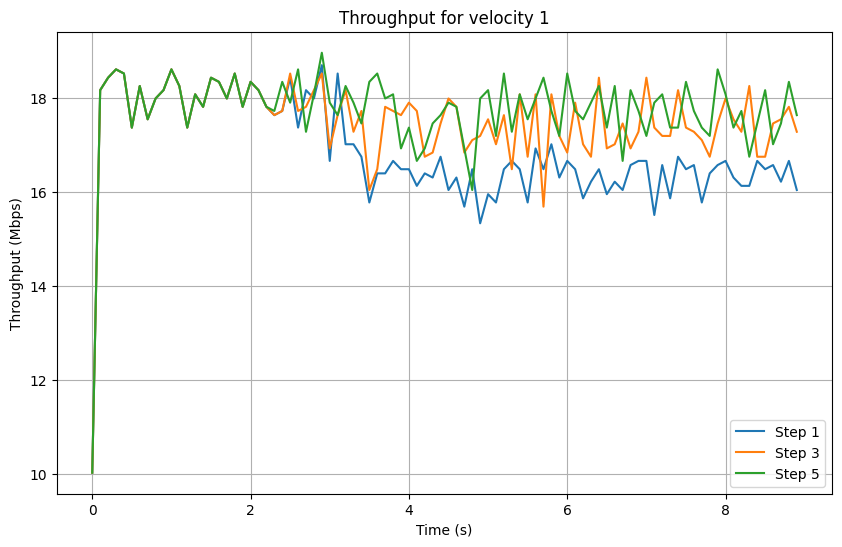

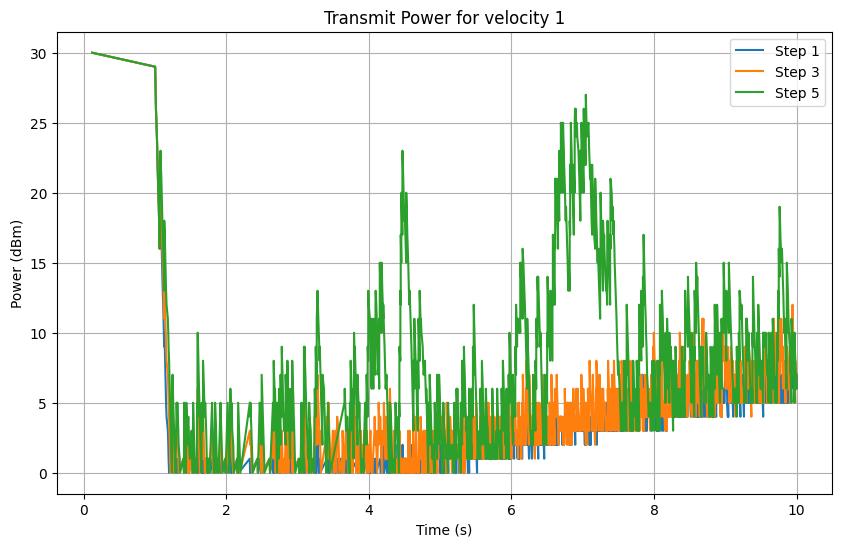

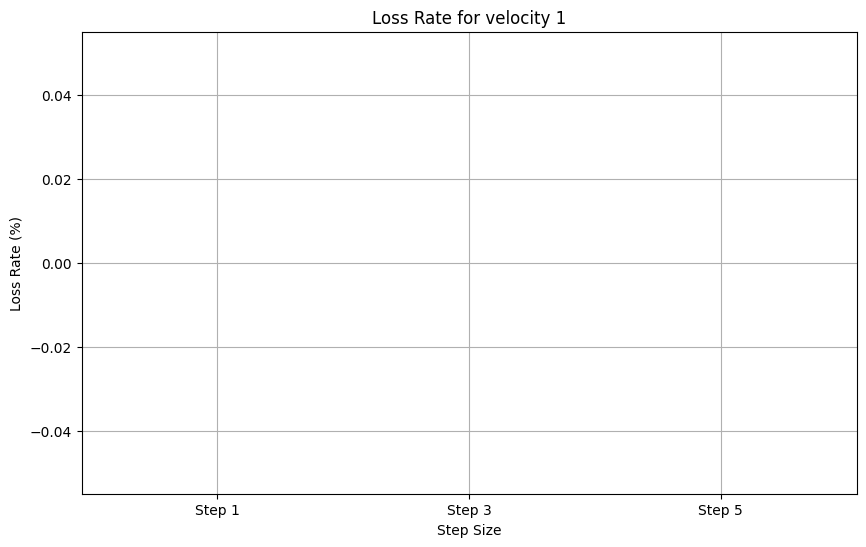

Loss rate for v=1, step=1: 0.00%
Loss rate for v=1, step=3: 0.00%
Loss rate for v=1, step=5: 0.00%


In [26]:
plot_metrics(1, [1, 3, 5])

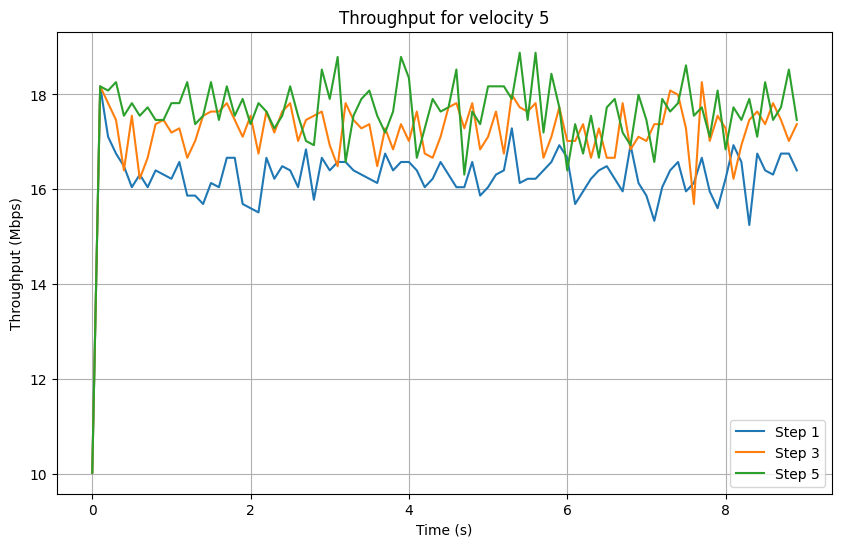

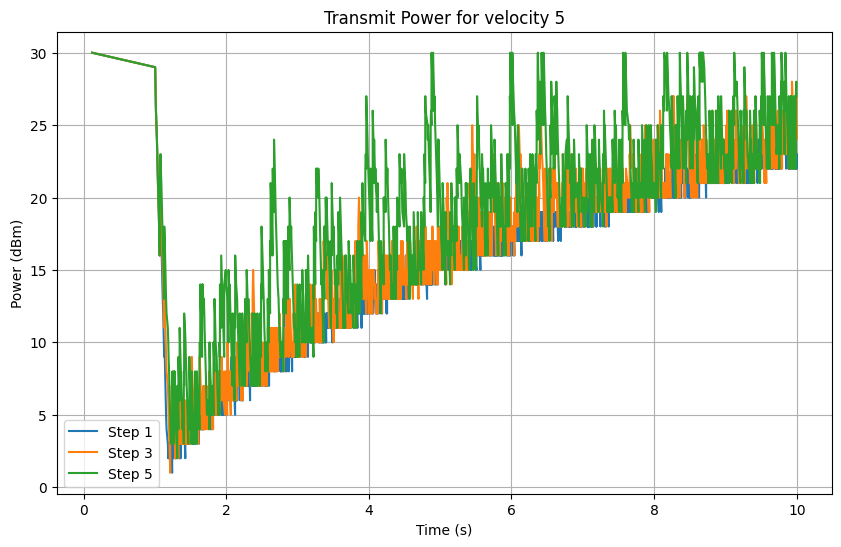

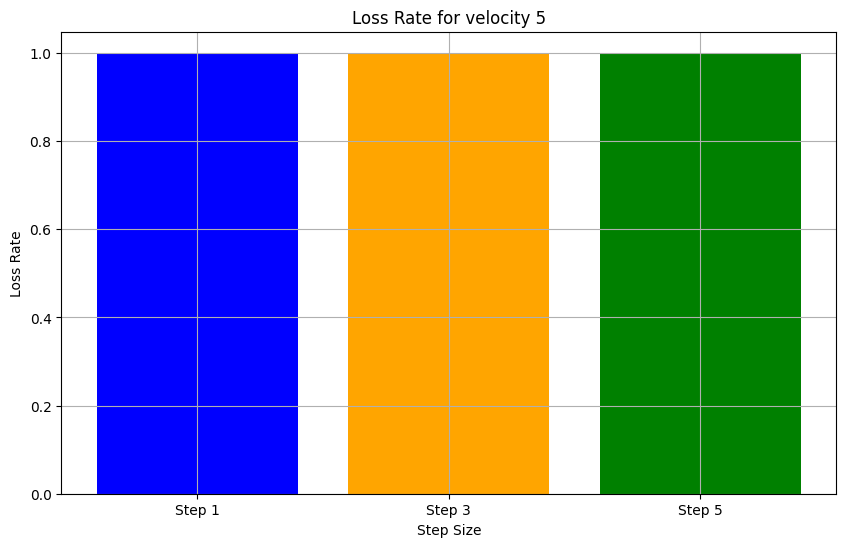

Loss rate for v=5, step=1: 99.82%
Loss rate for v=5, step=3: 99.82%
Loss rate for v=5, step=5: 99.82%


In [21]:
plot_metrics(5, [1, 3, 5])

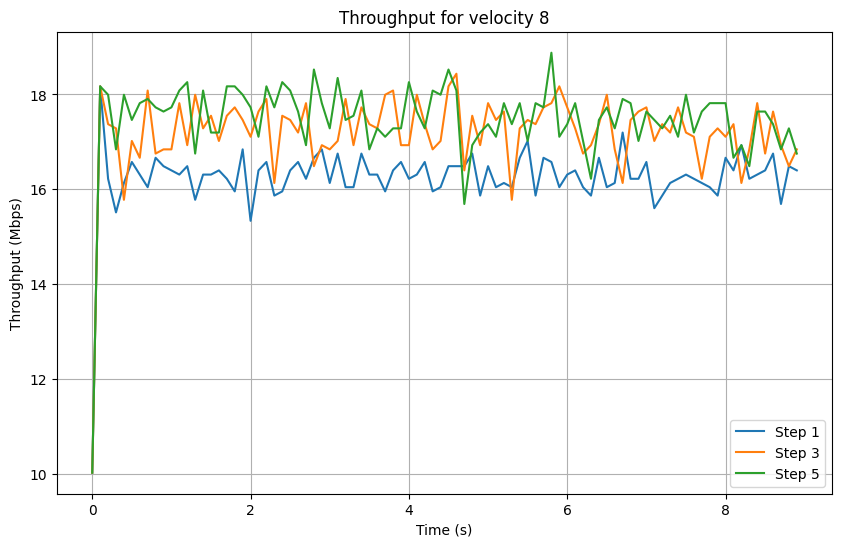

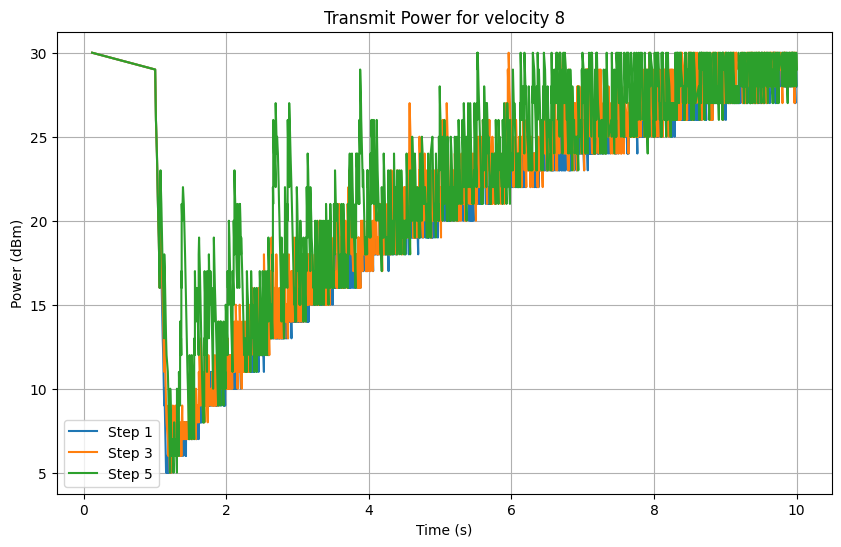

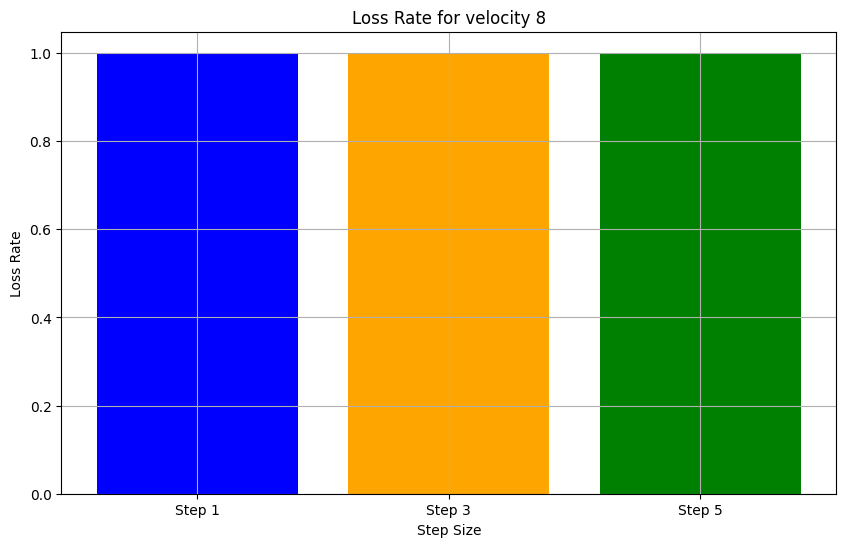

Loss rate for v=8, step=1: 99.82%
Loss rate for v=8, step=3: 99.82%
Loss rate for v=8, step=5: 99.82%


In [22]:
plot_metrics(8, [1, 3, 5])

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

def parse_tcp_file(filename):
    """Parses the TCP packet log file to extract time and packet sizes."""
    data = pd.read_csv(filename, names=["Time", "SrcPort", "DstPort", "Length"], skiprows=1)
    data["Time"] = pd.to_numeric(data["Time"], errors='coerce')
    data["Length"] = pd.to_numeric(data["Length"], errors='coerce')
    return data

def parse_tx_power_file(filename):
    """Parses the TX power log file to extract time and power values."""
    times = []
    powers = []

    with open(filename, 'r') as file:
        for line in file:
            match = re.search(r'Time: ([\d\.]+)s.*New Power: ([-\d]+) dBm', line)
            if match:
                times.append(float(match.group(1)))
                powers.append(int(match.group(2)))

    return pd.DataFrame({"Time": times, "Power": powers})

def compute_throughput(tcp_data, window_size=0.1):
    """Compute TCP throughput using a sliding window."""
    time_range = np.arange(tcp_data["Time"].min(), tcp_data["Time"].max(), window_size)
    thr_output = []
    for t in time_range:
        filtered = tcp_data[(tcp_data["Time"] >= t - window_size / 2) & (tcp_data["Time"] < t + window_size / 2)]
        throughput = (filtered["Length"].sum() * 8) / (window_size * 1e6) if not filtered.empty else 0  # Convert to Mbps
        thr_output.append([t, throughput])
    return pd.DataFrame(thr_output, columns=["Time", "Throughput"])

def compute_loss_rate(ap_data, ms_data):
    """Computes packet loss rate using bytes sent from AP vs bytes received at MS."""
    total_sent_bytes = ap_data["Length"].sum()  # Total de bytes enviados por el AP
    total_received_bytes = ms_data["Length"].sum()  # Total de bytes recibidos por el MS

    # Evitar división por cero
    if total_sent_bytes > 0:
        loss_rate = (total_sent_bytes - total_received_bytes) / total_sent_bytes
    else:
        loss_rate = 0

    return loss_rate

def plot_metrics(vel, step_sizes):
    """Plots throughput, transmit power, and loss rate for given velocity, showing stepSize variations in one figure."""

    avg_throughputs = []  # Lista para guardar los throughput medios
    avg_tx_powers = []  # Lista para guardar los transmit power medios
    loss_rates = []  # Lista para loss rates

    # Graficar el Throughput
    plt.figure(figsize=(10, 6))
    for step in step_sizes:
        tcp_file = f"tcp_pack_vel{vel}_step{step}.csv"
        ms_data = parse_tcp_file(tcp_file)
        throughput_data = compute_throughput(ms_data)

        avg_throughput = throughput_data["Throughput"].mean()  # Calcular el promedio
        avg_throughputs.append(avg_throughput)

        plt.plot(throughput_data["Time"], throughput_data["Throughput"], label=f"Step {step}")
    plt.xlabel("Time (s)")
    plt.ylabel("Throughput (Mbps)")
    plt.title(f"Throughput for velocity {vel}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Graficar el Transmit Power
    plt.figure(figsize=(10, 6))
    for step in step_sizes:
        tx_power_file = f"tx_power_vel{vel}_step{step}.txt"
        tx_power_data = parse_tx_power_file(tx_power_file)

        avg_tx_power = tx_power_data["Power"].mean()  # Calcular el promedio
        avg_tx_powers.append(avg_tx_power)

        plt.plot(tx_power_data["Time"], tx_power_data["Power"], label=f"Step {step}")
    plt.xlabel("Time (s)")
    plt.ylabel("Power (dBm)")
    plt.title(f"Transmit Power for velocity {vel}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Graficar el Loss Rate
    plt.figure(figsize=(10, 6))
    for step in step_sizes:
        ms_file = f"tcp_pack_vel{vel}_step{step}.csv"   # PCAP del Mobile Station (MS)
        ap_file = f"tcp_pack_ap_vel{vel}_step{step}.csv" # PCAP del Access Point (AP)

        ms_data = parse_tcp_file(ms_file)
        ap_data = parse_tcp_file(ap_file)

        loss_rate = compute_loss_rate(ap_data, ms_data)
        loss_rates.append(loss_rate)

    plt.bar([f"Step {s}" for s in step_sizes], loss_rates, color=['blue', 'orange', 'green'])
    plt.xlabel("Step Size")
    plt.ylabel("Loss Rate")
    plt.title(f"Loss Rate for velocity {vel}")
    plt.grid(True)
    plt.show()

    # Imprimir métricas
    print("\n===== Summary of Metrics =====")
    for step, thr, tx, loss in zip(step_sizes, avg_throughputs, avg_tx_powers, loss_rates):
        print(f"Velocity {vel} - Step {step}:")
        print(f"  - Avg Throughput: {thr:.2f} Mbps")
        print(f"  - Avg Transmit Power: {tx:.2f} dBm")
        print(f"  - Loss Rate: {loss:.2%}")

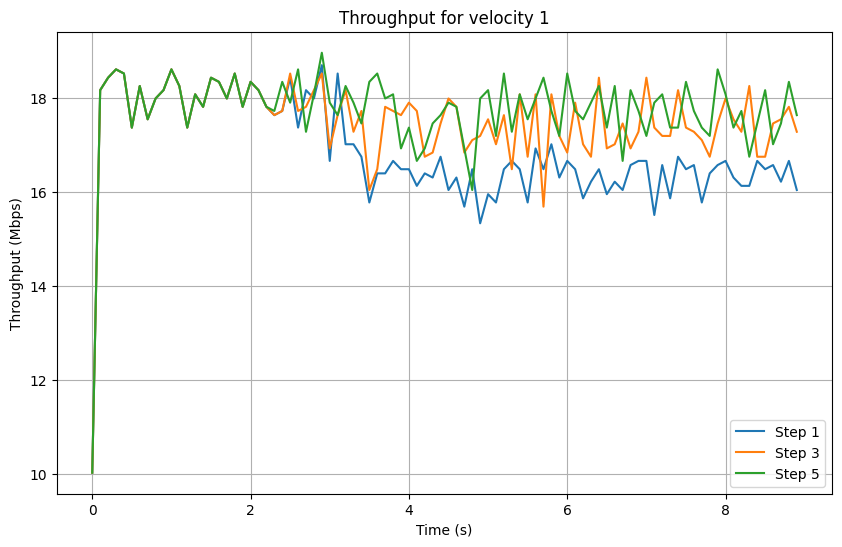

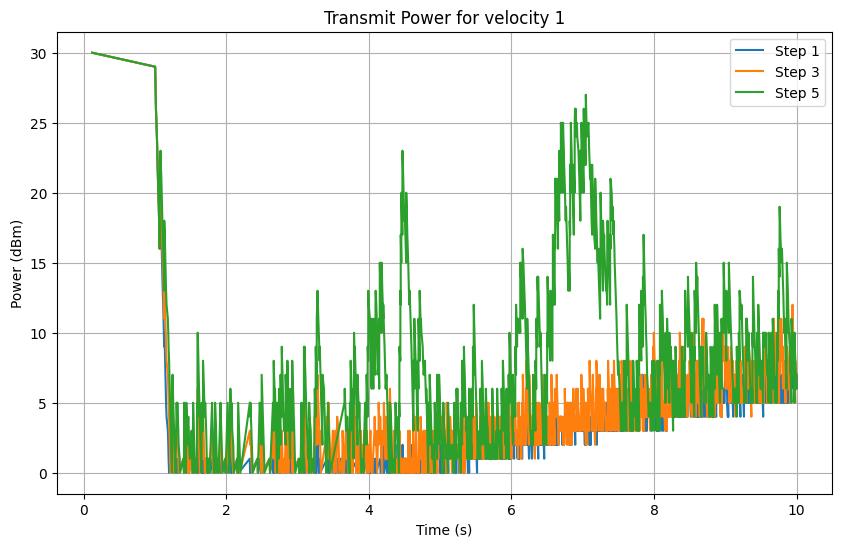

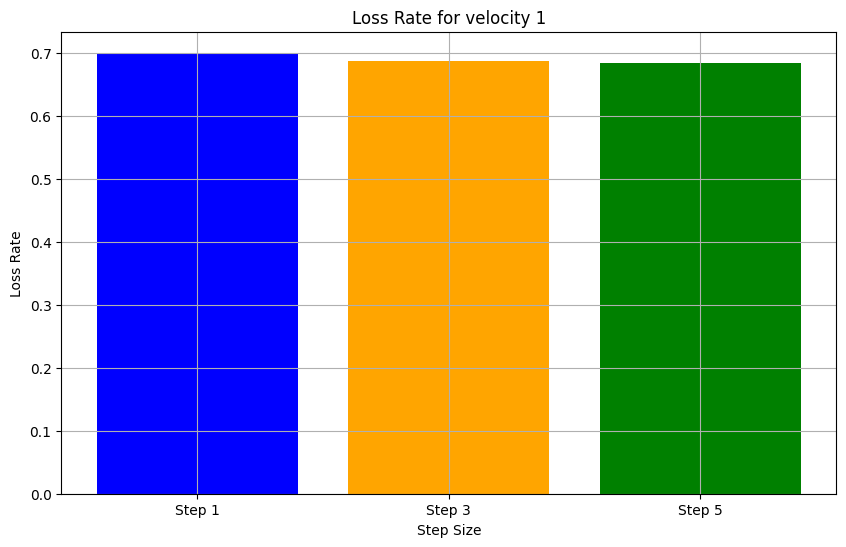


===== Summary of Metrics =====
Velocity 1 - Step 1:
  - Avg Throughput: 16.87 Mbps
  - Avg Transmit Power: 3.30 dBm
  - Loss Rate: 69.88%
Velocity 1 - Step 3:
  - Avg Throughput: 17.51 Mbps
  - Avg Transmit Power: 4.19 dBm
  - Loss Rate: 68.76%
Velocity 1 - Step 5:
  - Avg Throughput: 17.74 Mbps
  - Avg Transmit Power: 8.05 dBm
  - Loss Rate: 68.35%


In [13]:
plot_metrics(1, [1, 3, 5])

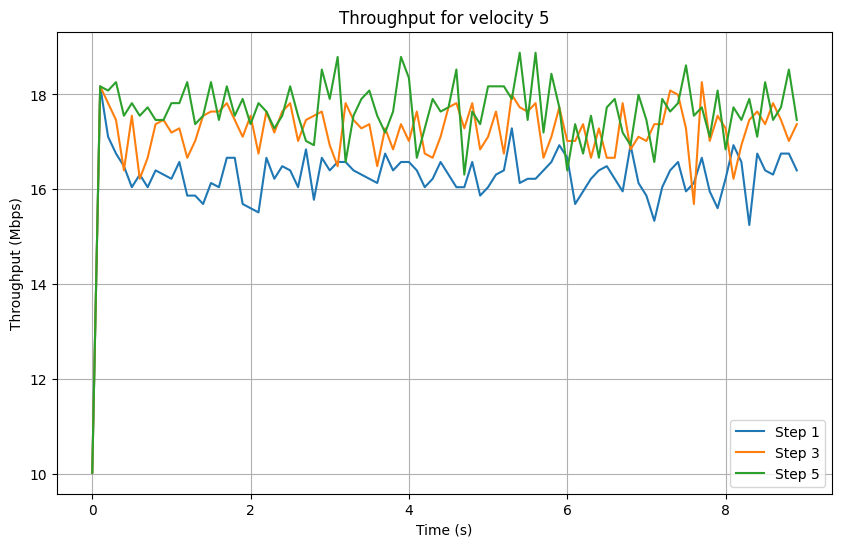

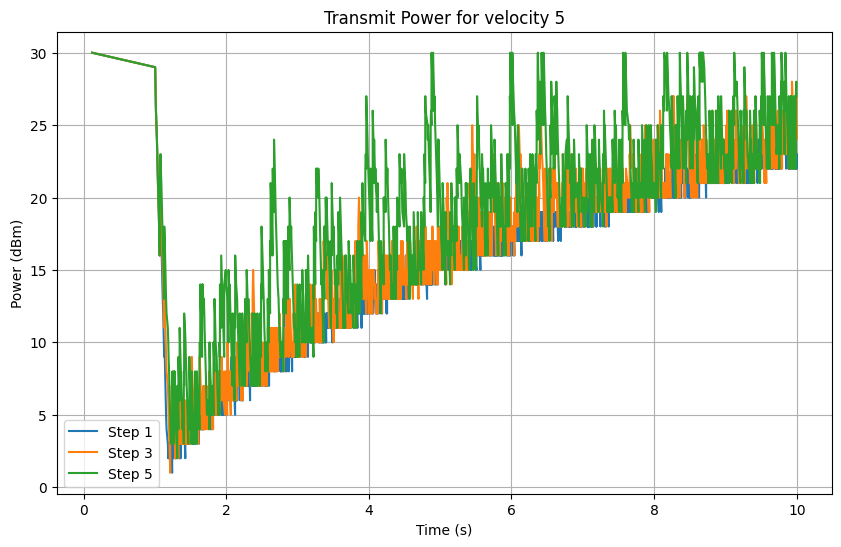

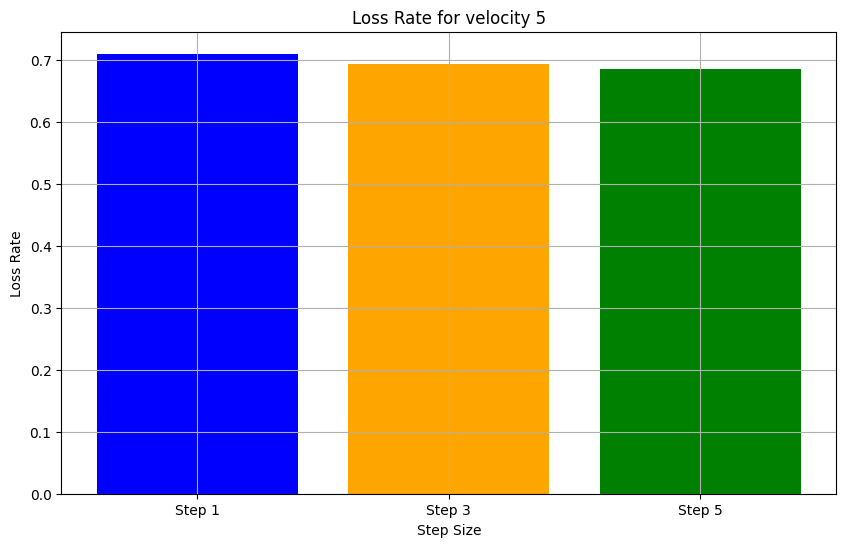


===== Summary of Metrics =====
Velocity 5 - Step 1:
  - Avg Throughput: 16.25 Mbps
  - Avg Transmit Power: 15.37 dBm
  - Loss Rate: 70.99%
Velocity 5 - Step 3:
  - Avg Throughput: 17.20 Mbps
  - Avg Transmit Power: 16.50 dBm
  - Loss Rate: 69.31%
Velocity 5 - Step 5:
  - Avg Throughput: 17.60 Mbps
  - Avg Transmit Power: 18.78 dBm
  - Loss Rate: 68.60%


In [15]:
plot_metrics(5, [1, 3, 5])

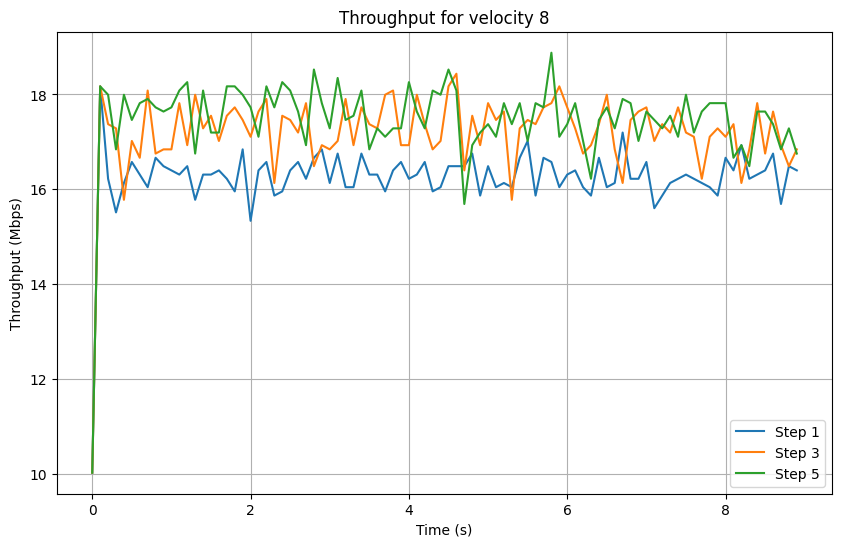

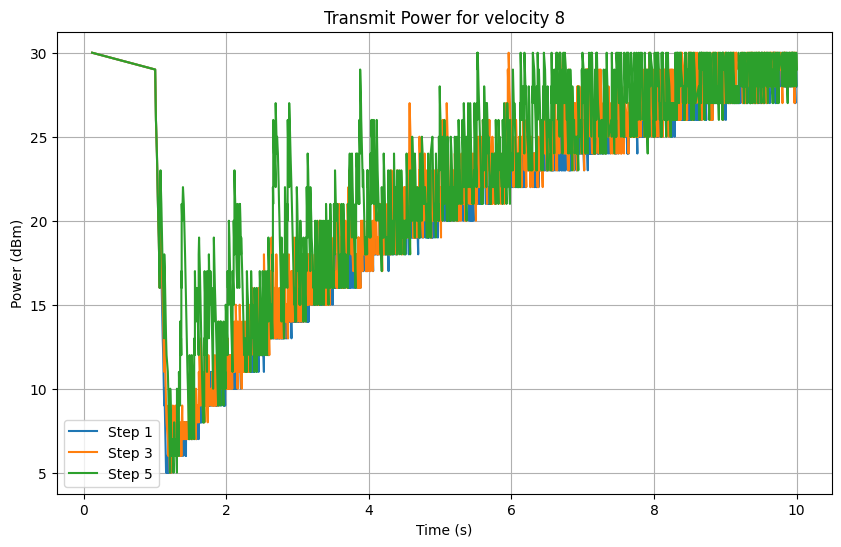

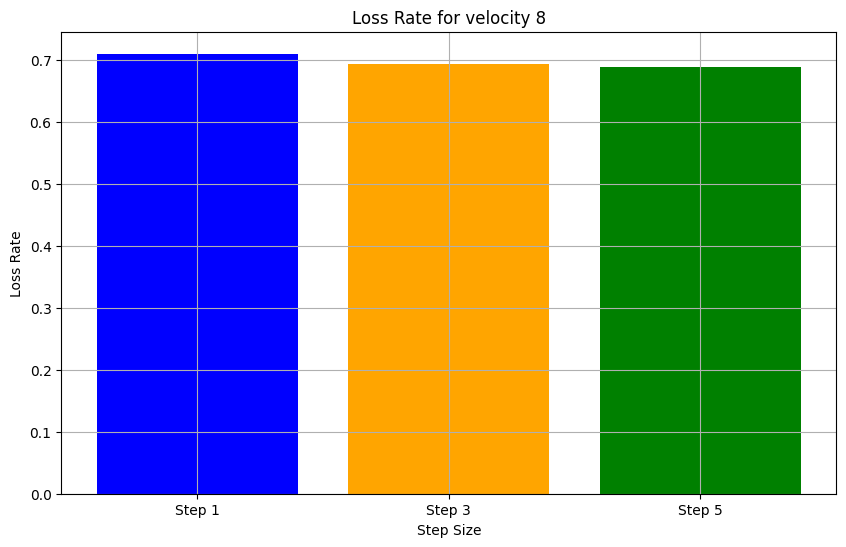


===== Summary of Metrics =====
Velocity 8 - Step 1:
  - Avg Throughput: 16.25 Mbps
  - Avg Transmit Power: 20.45 dBm
  - Loss Rate: 71.00%
Velocity 8 - Step 3:
  - Avg Throughput: 17.19 Mbps
  - Avg Transmit Power: 21.24 dBm
  - Loss Rate: 69.34%
Velocity 8 - Step 5:
  - Avg Throughput: 17.47 Mbps
  - Avg Transmit Power: 22.60 dBm
  - Loss Rate: 68.84%


In [16]:
plot_metrics(8, [1, 3, 5])

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

def parse_tcp_file(filename):
    """Parses the TCP packet log file to extract time and packet sizes."""
    data = pd.read_csv(filename, names=["Time", "SrcPort", "DstPort", "Length"], skiprows=1)
    data["Time"] = pd.to_numeric(data["Time"], errors='coerce')
    data["Length"] = pd.to_numeric(data["Length"], errors='coerce')
    return data

def parse_tx_power_file(filename):
    """Parses the TX power log file to extract time and power values."""
    times = []
    powers = []

    with open(filename, 'r') as file:
        for line in file:
            match = re.search(r'Time: ([\d\.]+)s.*New Power: ([-\d]+) dBm', line)
            if match:
                times.append(float(match.group(1)))
                powers.append(int(match.group(2)))

    return pd.DataFrame({"Time": times, "Power": powers})

def smooth_tx_power(tx_power_data, window_size=0.2):
    """Applies a moving average to smooth the transmit power data."""
    time_range = np.arange(tx_power_data["Time"].min(), tx_power_data["Time"].max(), window_size)
    smoothed_output = []

    for t in time_range:
        filtered = tx_power_data[(tx_power_data["Time"] >= t - window_size / 2) &
                                 (tx_power_data["Time"] < t + window_size / 2)]
        avg_power = filtered["Power"].mean() if not filtered.empty else np.nan
        smoothed_output.append([t, avg_power])

    return pd.DataFrame(smoothed_output, columns=["Time", "Power"])

def compute_throughput(tcp_data, window_size=0.1):
    """Compute TCP throughput using a sliding window."""
    time_range = np.arange(tcp_data["Time"].min(), tcp_data["Time"].max(), window_size)
    thr_output = []
    for t in time_range:
        filtered = tcp_data[(tcp_data["Time"] >= t - window_size / 2) & (tcp_data["Time"] < t + window_size / 2)]
        throughput = (filtered["Length"].sum() * 8) / (window_size * 1e6) if not filtered.empty else 0  # Convert to Mbps
        thr_output.append([t, throughput])
    return pd.DataFrame(thr_output, columns=["Time", "Throughput"])

def compute_loss_rate(ap_data, ms_data):
    """Computes packet loss rate using bytes sent from AP vs bytes received at MS."""
    total_sent_bytes = ap_data["Length"].sum()  # Total de bytes enviados por el AP
    total_received_bytes = ms_data["Length"].sum()  # Total de bytes recibidos por el MS

    # Evitar división por cero
    if total_sent_bytes > 0:
        loss_rate = (total_sent_bytes - total_received_bytes) / total_sent_bytes
    else:
        loss_rate = 0

    return loss_rate

def plot_metrics(vel, step_sizes):
    """Plots throughput, transmit power, and loss rate for given velocity, showing stepSize variations in one figure."""

    avg_throughputs = []  # Lista para guardar los throughput medios
    avg_tx_powers = []  # Lista para guardar los transmit power medios
    loss_rates = []  # Lista para loss rates

    # Graficar el Throughput
    plt.figure(figsize=(10, 6))
    for step in step_sizes:
        tcp_file = f"tcp_pack_vel{vel}_step{step}.csv"
        ms_data = parse_tcp_file(tcp_file)
        throughput_data = compute_throughput(ms_data)

        avg_throughput = throughput_data["Throughput"].mean()  # Calcular el promedio
        avg_throughputs.append(avg_throughput)

        plt.plot(throughput_data["Time"], throughput_data["Throughput"], label=f"Step {step}")
    plt.xlabel("Time (s)")
    plt.ylabel("Throughput (Mbps)")
    plt.title(f"Throughput for velocity {vel}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Graficar el Transmit Power (Suavizado)
    plt.figure(figsize=(10, 6))
    for step in step_sizes:
        tx_power_file = f"tx_power_vel{vel}_step{step}.txt"
        tx_power_data = parse_tx_power_file(tx_power_file)
        smoothed_tx_power = smooth_tx_power(tx_power_data)  # Suavizar datos

        avg_tx_power = smoothed_tx_power["Power"].mean()  # Calcular el promedio
        avg_tx_powers.append(avg_tx_power)

        plt.plot(smoothed_tx_power["Time"], smoothed_tx_power["Power"], label=f"Step {step}")
    plt.xlabel("Time (s)")
    plt.ylabel("Power (dBm)")
    plt.title(f"Transmit Power for velocity {vel} (Smoothed)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Graficar el Loss Rate
    plt.figure(figsize=(10, 6))
    for step in step_sizes:
        ms_file = f"tcp_pack_vel{vel}_step{step}.csv"   # PCAP del Mobile Station (MS)
        ap_file = f"tcp_pack_ap_vel{vel}_step{step}.csv" # PCAP del Access Point (AP)

        ms_data = parse_tcp_file(ms_file)
        ap_data = parse_tcp_file(ap_file)

        loss_rate = compute_loss_rate(ap_data, ms_data)
        loss_rates.append(loss_rate)

    plt.bar([f"Step {s}" for s in step_sizes], loss_rates, color=['blue', 'orange', 'green'])
    plt.xlabel("Step Size")
    plt.ylabel("Loss Rate")
    plt.title(f"Loss Rate for velocity {vel}")
    plt.grid(True)


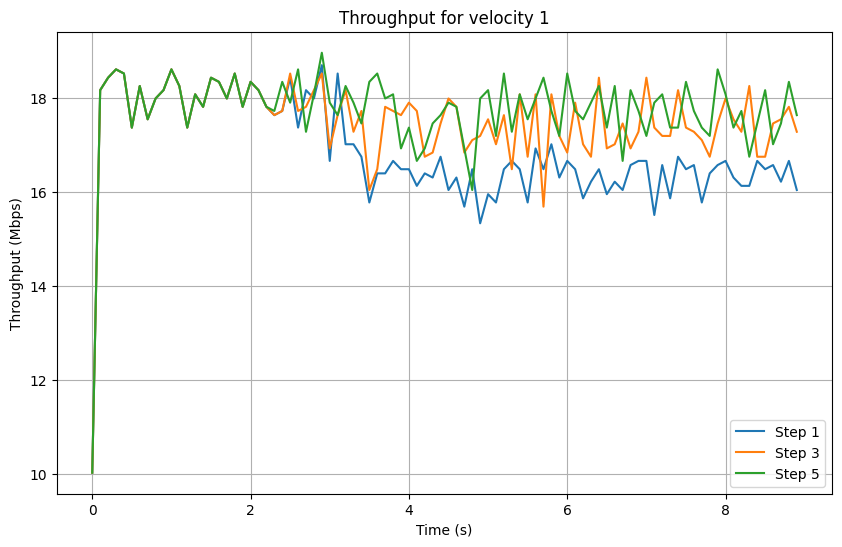

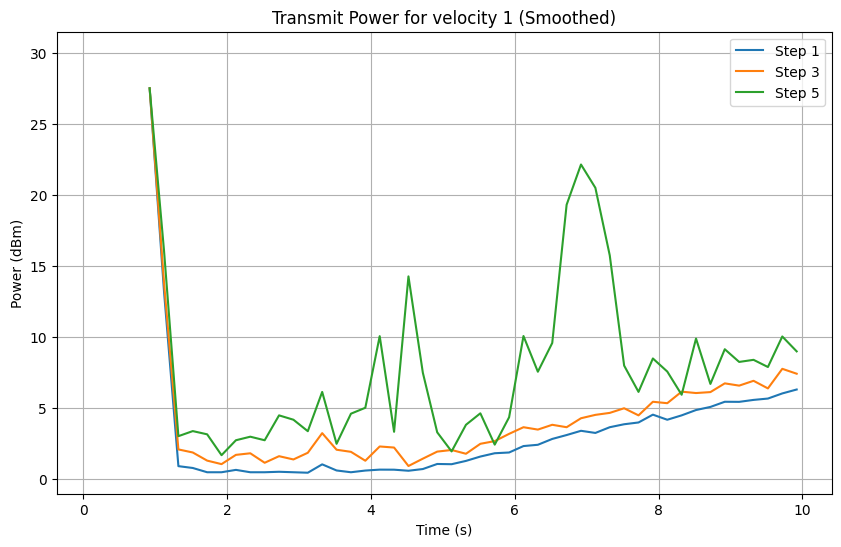

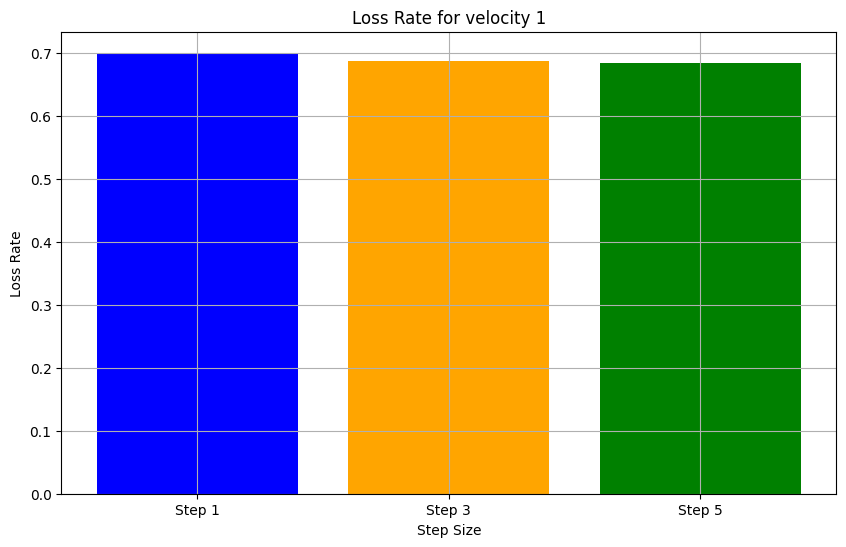

In [36]:
plot_metrics(1, [1, 3, 5])

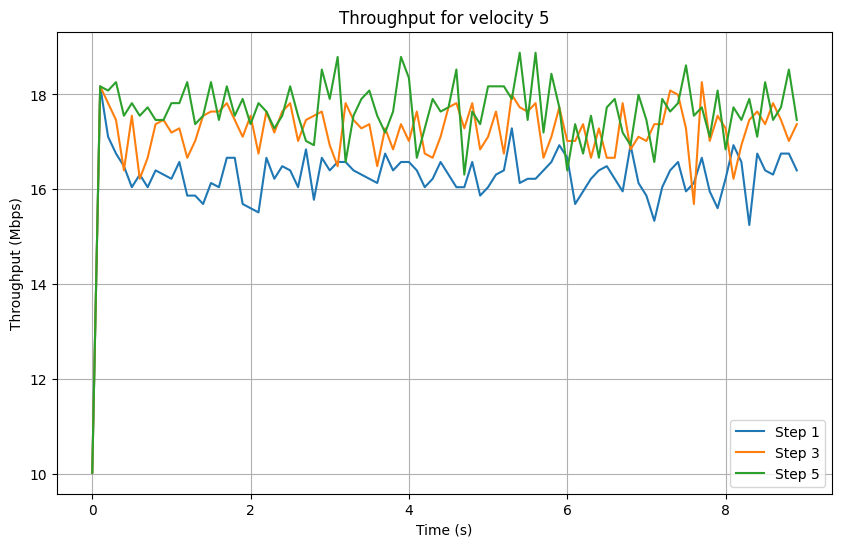

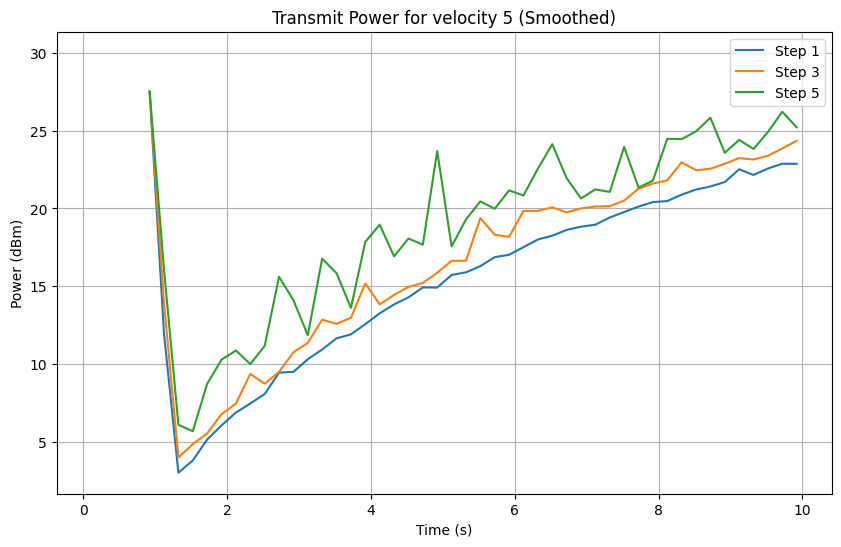

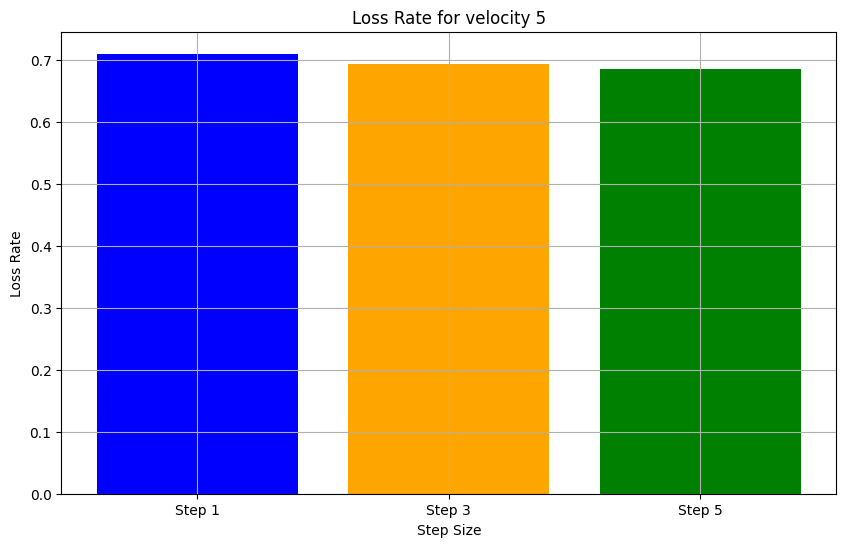

In [37]:
plot_metrics(5, [1, 3, 5])

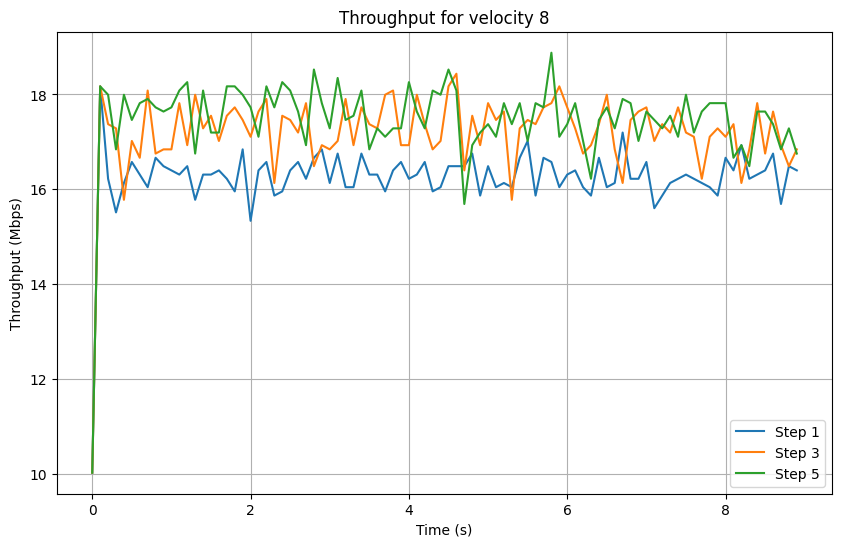

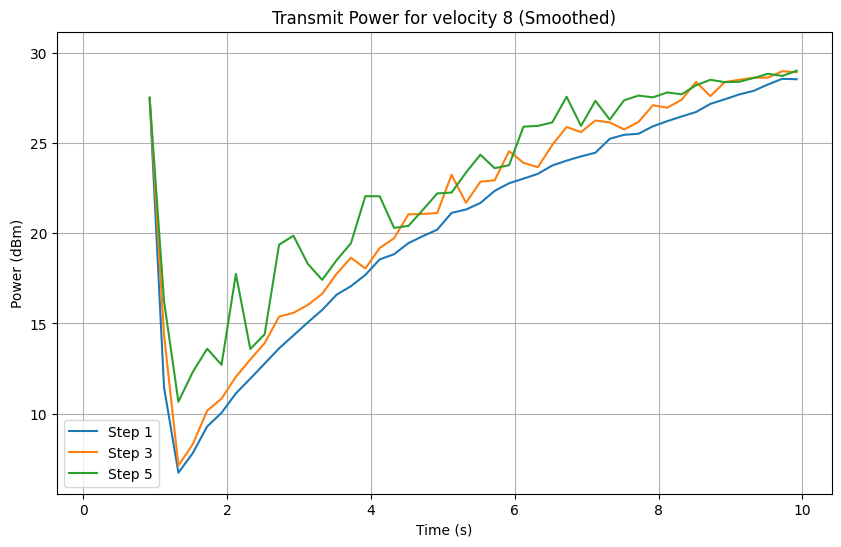

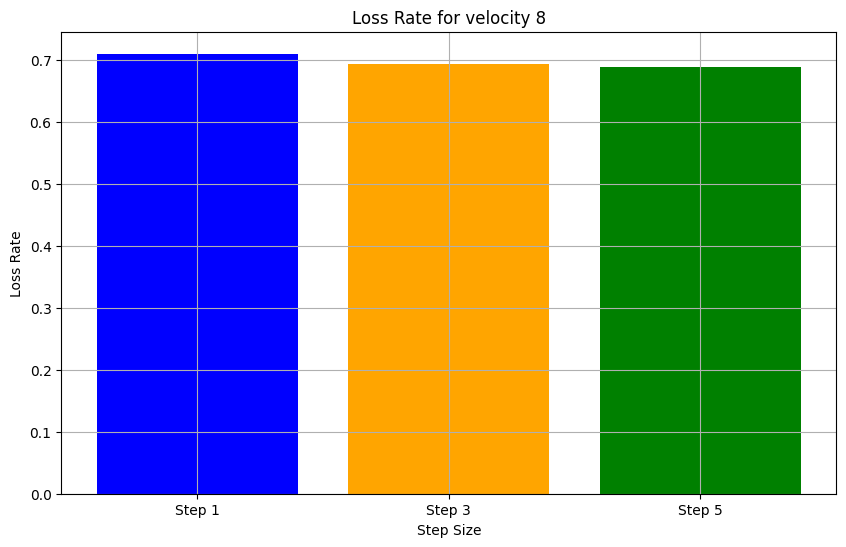

In [38]:
plot_metrics(8, [1, 3, 5])